<a href="https://colab.research.google.com/github/vitroid/GenIce/blob/genice2/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tests to run GenIce on Jupyter and Google Colaboratory.

In [ ]:
# GenIce2 is not available in PyPI for now.
# %pip install genice2

# Instead, install them from github repository.
! git clone -b genice2 https://github.com/vitroid/GenIce.git
! cd GenIce; python setup.py install
# and restart the python kernel
import os
os._exit(0)

A simplest sample.

In [1]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "ice11_19").Lattice() 
formatter  = safe_import("format", "gromacs").Format()
water      = safe_import("molecule", "spce").Molecule()
ice = GenIce(lattice).generate_ice(water, formatter)
print(ice)

Generated by GenIce https://github.com/vitroid/GenIce 
48
    1SOL     Ow    1   0.220  -0.003   0.095
    1SOL     Hw    2   0.302  -0.050   0.062
    1SOL     Hw    3   0.220   0.092   0.062
    2SOL     Ow    4   0.220   0.256   0.004
    2SOL     Hw    5   0.302   0.304   0.037
    2SOL     Hw    6   0.220   0.256  -0.096
    3SOL     Ow    7   0.229   0.003   0.370
    3SOL     Hw    8   0.229   0.003   0.270
    3SOL     Hw    9   0.148  -0.045   0.404
    4SOL     Ow   10   0.229   0.262   0.462
    4SOL     Hw   11   0.148   0.309   0.429
    4SOL     Hw   12   0.229   0.167   0.429
    5SOL     Ow   13   0.669  -0.003   0.095
    5SOL     Hw   14   0.751  -0.050   0.062
    5SOL     Hw   15   0.669   0.092   0.062
    6SOL     Ow   16   0.669   0.256   0.004
    6SOL     Hw   17   0.669   0.256  -0.096
    6SOL     Hw   18   0.751   0.304   0.037
    7SOL     Ow   19   0.678   0.003   0.370
    7SOL     Hw   20   0.678   0.003   0.270
    7SOL     Hw   21   0.597  -0.045   0.4

Install an extra package to show image inline.

In [ ]:
# New genice-svg is not available for now.
# %pip install genice_svg

# Instead, install them from github repository.
! rm -rf genice-svg
! pip uninstall -y genice-svg genice2_svg
! git clone -b genice2 https://github.com/vitroid/genice-svg.git
! cd genice-svg; python setup.py install
# and restart the python kernel
import os
os._exit(0)

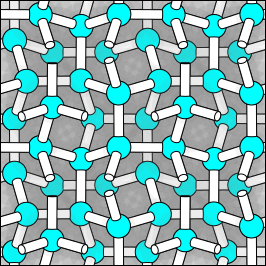

In [2]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "ice3").Lattice() 
formatter  = safe_import("format", "svg").Format(shadow=True)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

from IPython.display import SVG, display
display(SVG(img))

PNG renderer is also included in genice_svg package.

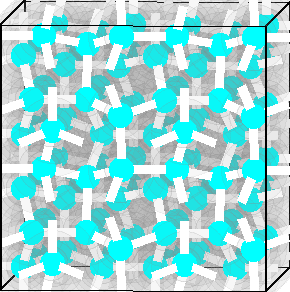

In [3]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "ice3").Lattice() 
formatter  = safe_import("format", "png").Format(shadow="#8881",encode=False,bg="#fff",rotatex=5,rotatey=5)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

from IPython.display import display
display(img)

Or save it in a PNG file.

In [4]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "ice3").Lattice() 
formatter  = safe_import("format", "png").Format(shadow="#8881",encode=True,bg="#fff",rotatex=5,rotatey=5)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

with open("ice3.png", "wb") as f:
    f.write(img)

Some statistical analyses are also available.

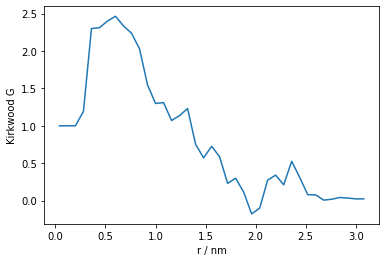

In [5]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "T").Lattice() 
formatter  = safe_import("format", "_KG").Format()
water      = safe_import("molecule", "spce").Molecule()
result = GenIce(lattice).generate_ice(water, formatter)

import numpy as np
from matplotlib import pyplot as plt

kg = np.fromstring(result, dtype=float, sep=" ")
N = kg.shape[0]
kg = kg.reshape([N//2, 2])
plt.plot(kg[:,0], kg[:,1])
plt.xlabel("r / nm")
plt.ylabel("Kirkwood G")
plt.show()

You may want to see the process log.

In [6]:
from logging import getLogger, INFO, DEBUG, WARNING
logger = getLogger()
logger.setLevel(INFO)

from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice   = safe_import("lattice", "1c").Lattice() 
formatter = safe_import("format", "gromacs").Format()
water     = safe_import("molecule", "spce").Molecule()
ice = GenIce(lattice, signature="Jupyter test").generate_ice(water, formatter)
print(ice)

logger.setLevel(WARNING)

INFO:root:  
INFO:root:  Jupyter test
INFO:root:No rotmatrices in lattice
INFO:root:Cell dimension:
INFO:root:  a = 4.0
INFO:root:  b = 4.0
INFO:root:  c = 4.0
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:Bond length (specified): 1.9
INFO:root:Target Density: 0.92
INFO:root:Original Density: 0.0037363002324809044
INFO:root:Bond length (scaled, nm): 0.3031365108343017
INFO:root:Stage1: Replication.
INFO:root:  Number of water molecules: 8
INFO:root:  Number of water nodes: 8
INFO:root:Cell dimension:
INFO:root:  a = 0.6381821280722142
INFO:root:  b = 0.6381821280722142
INFO:root:  c = 0.6381821280722142
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:Stage1: end.
INFO:root:Stage2: Graph preparation.
INFO:root:  Number of pre-oriented hydrogen bonds: 0
INFO:root:  Number of unoriented hydrogen bonds: 16
INFO:root:  Number of hydrogen bonds: 16 (regular num: 16)
INFO:root:Stage2: end.
INFO:root:Stage3: Bernal-Fowler rule.
INFO:root:  De

Generated by GenIce https://github.com/vitroid/GenIce 
24
    1SOL     Ow    1   0.000   0.006   0.000
    1SOL     Hw    2  -0.058  -0.051   0.058
    1SOL     Hw    3   0.058  -0.051  -0.058
    2SOL     Ow    4   0.319   0.313   0.000
    2SOL     Hw    5   0.261   0.370  -0.058
    2SOL     Hw    6   0.377   0.370   0.058
    3SOL     Ow    7   0.319  -0.006   0.319
    3SOL     Hw    8   0.377   0.051   0.377
    3SOL     Hw    9   0.261   0.051   0.261
    4SOL     Ow   10   0.000   0.326   0.319
    4SOL     Hw   11   0.058   0.268   0.261
    4SOL     Hw   12  -0.058   0.268   0.377
    5SOL     Ow   13   0.160   0.160   0.166
    5SOL     Hw   14   0.102   0.102   0.108
    5SOL     Hw   15   0.217   0.217   0.108
    6SOL     Ow   16   0.479   0.479   0.153
    6SOL     Hw   17   0.536   0.421   0.211
    6SOL     Hw   18   0.421   0.536   0.211
    7SOL     Ow   19   0.479   0.160   0.472
    7SOL     Hw   20   0.421   0.217   0.530
    7SOL     Hw   21   0.536   0.102   0.5

You can access the "raw" (internal) data.

In [7]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "xFAU2").Lattice(rep=3) 
formatter  = safe_import("format", "raw").Format(stage=(1,))
water      = safe_import("molecule", "spce").Molecule()
raw = GenIce(lattice, signature="Aeroice 3xFAU").generate_ice(water, formatter)

raw

{'cagetypes': None,
 'repcagepos': None,
 'repcagetype': None,
 'repcell': array([[3.47347586, 0.        , 0.        ],
        [0.        , 3.47347586, 0.        ],
        [0.        , 0.        , 3.47347586]]),
 'reppositions': array([[1.38777878e-17, 1.12372436e-01, 5.61862178e-02],
        [1.38777878e-17, 5.61862178e-02, 1.12372436e-01],
        [5.61862178e-02, 1.38777878e-17, 1.12372436e-01],
        ...,
        [1.37627564e-01, 6.93813782e-01, 7.50000000e-01],
        [1.93813782e-01, 6.37627564e-01, 7.50000000e-01],
        [2.50000000e-01, 6.37627564e-01, 6.93813782e-01]])}

Use the raw data to plot by yourself.

In [8]:
waters = raw["reppositions"]
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x = waters[:,0], 
                                   y = waters[:,1], 
                                   z = waters[:,2],
                                   marker=dict(size=3),
                                   mode = 'markers'
                                   )])
fig.show()